In [238]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from catboost import CatBoostClassifier as catb
import xgboost as xgb, lightgbm as lgbm

In [239]:
import warnings
warnings.filterwarnings('ignore')

In [240]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plot_params = {'ytick.color' : 'w',
               'xtick.color' : 'w',
               'axes.labelcolor' : 'w',
               'axes.edgecolor' : 'w',
               'text.color': 'w',
               'legend.facecolor': 'k'}
plt.rcParams.update(plot_params)

In [241]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [242]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [243]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (8, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [244]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (10, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

### Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

### План работы
**Построение модели классификации**
1. [Объединить датасеты и сделать обзор](#review)
4. [Анализ данных](#analysis)
2. [Обработка выбросов](#outliers)
3. [Обработка пропусков](#gaps)
5. [Построение новых признаков](#feature_engineering)
6. [Отбор признаков](#feature_importances)
7. [Нормализация данных](#normalize)
8. [Разбиение на train и test](#train_test)
9. [Балансировка целевого класса](#class_balance)
7. [Подбор моделей, получение baseline](#baseline)
8. [Подбор гиперпараметров лучшей модели](#tuning)
9. [Проверка качества, борьба с переобучением](#overfitting)
10.[Вывод](#conclusions)

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

**Выводы**
- Ключевая метрика __F1__ > 0.5
- Описать результаты моделей, которые использовал, рассказать почему остановился на последней

### Объединить датасеты и сделать обзор<a class="anchor" id="review"></a>

**Загрузка данных**

In [245]:
# input
TEST_DATASET_PATH = './course_project_test.csv'
TRAIN_DATASET_PATH = './course_project_train.csv'

# output
SCALER_FILE_PATH = './scaler.pkl'
TRAIN_FULL_PATH = './course_project_train_full.csv'
TRAIN_PART_PATH = './course_project_train_part.csv'
TEST_PART_PATH = './course_project_test_part.csv'

In [246]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

**Описание датасета:**

* **Home Ownership** - Вид домовладения;
* **Annual Income** - Годовой доход;
* **Years in current job** - Стаж на текущем рабочем месте;
* **Tax Liens** - Налоговый залог;
* **Number of Open Accounts** - Количество открытых счетов;
* **Years of Credit History** - Срок кредитной истории;
* **Maximum Open Credit** - Максимальный размер открытого кредита;
* **Number of Credit Problems** - Число проблем с кредитом;
* **Months since last delinquent** - Число месяцев с момента последней просрочки;
* **Bankruptcies** - Число банкротств;
* **Purpose** - Цели займа;
* **Term** - Срок займа;
* **Current Loan Amount** - Размер текущего займа;
* **Current Credit Balance** - Текущий кредитный баланс;
* **Monthly Debt** - Ежемесячный платёж;
* **Credit Score** - Индекс кредитоспособности;
* <font color='orange'>**Credit Default**</font> - Просрочка платежа в следующем месяце (1=да, 0=нет);

**Сравнение размерностей _train_ и _test_**

In [247]:
train_df.shape[1]-1 == test_df.shape[1]

True

**Объединение датасетов**

In [248]:
data = pd.concat([train_df, test_df], axis=0)
data = data.reset_index(drop=True)

**Обзор**

In [249]:
data.head(n=3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,"482,087.000",NaN,0.000,11.000,26.300,"685,960.000",1.000,nan,1.000,debt consolidation,Short Term,"99,999,999.000","47,386.000","7,914.000",749.000,0.000
1,Own Home,"1,025,487.000",10+ years,0.000,15.000,15.300,"1,181,730.000",0.000,nan,0.000,debt consolidation,Long Term,"264,968.000","394,972.000","18,373.000",737.000,1.000
2,Home Mortgage,"751,412.000",8 years,0.000,11.000,35.000,"1,182,434.000",0.000,nan,0.000,debt consolidation,Short Term,"99,999,999.000","308,389.000","13,651.000",742.000,0.000


**Выделение целевой переменной и групп признаков**

In [250]:
TARGET_NAME = "Credit Default"
BASE_FEATURE_NAMES = data.columns.drop(TARGET_NAME).tolist()

**Распределение целевой переменной**

In [251]:
data[TARGET_NAME].value_counts(normalize=True)

0.000   0.718
1.000   0.282
Name: Credit Default, dtype: float64

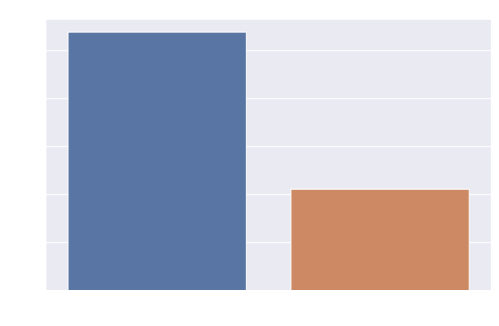

In [252]:
plt.figure(figsize=(8,5))

sns.countplot(x=TARGET_NAME,
              data=data)

plt.title('Target variable distribution')
plt.show()

**Вывод:**<br>
_Доля объектов целевого класса ~ 28%_<br>

**Обзор количественных признаков**

In [253]:
pd.options.display.float_format = '{:,.3f}'.format # запретить exp и отображать float до 3-го знака после запятой
data.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,"7,930.000","10,000.000","10,000.000","10,000.000","10,000.000","10,000.000","4,561.000","9,983.000","10,000.000","10,000.000","10,000.000","7,930.000","7,500.000"
mean,"1,366,524.510",0.031,11.144,18.320,"886,507.897",0.168,34.565,0.115,"11,943,812.992","291,474.089","18,303.676","1,171.992",0.282
std,"863,827.629",0.304,4.895,7.095,"13,899,818.885",0.515,21.772,0.350,"32,008,780.390","333,997.864","11,831.648","1,639.813",0.450
min,"106,533.000",0.000,1.000,3.900,0.000,0.000,0.000,0.000,"11,242.000",0.000,0.000,585.000,0.000
25%,"845,989.250",0.000,8.000,13.500,"278,811.500",0.000,16.000,0.000,"180,548.500","113,225.750","10,059.750",711.000,0.000
50%,"1,168,813.500",0.000,10.000,17.000,"478,181.000",0.000,32.000,0.000,"311,718.000","209,019.000","16,200.000",731.000,0.000
75%,"1,638,693.000",0.000,14.000,22.000,"794,359.500",0.000,50.000,0.000,"521,070.000","361,950.000","23,888.250",743.000,1.000
max,"14,975,610.000",15.000,48.000,57.700,"1,304,726,170.000",15.000,118.000,5.000,"99,999,999.000","6,506,797.000","136,679.000","7,510.000",1.000


**Обзор номинативных признаков**

In [254]:
for cat_colname in data.select_dtypes(include='object'):
    print(str(cat_colname) + '\n\n' + str(data[cat_colname].value_counts()) + '\n' + '=' * 100 +  '\n')

Home Ownership

Home Mortgage    4862
Rent             4224
Own Home          895
Have Mortgage      19
Name: Home Ownership, dtype: int64

Years in current job

10+ years    3142
2 years       917
3 years       848
< 1 year      770
5 years       685
1 year        657
4 years       621
6 years       563
7 years       536
8 years       446
9 years       358
Name: Years in current job, dtype: int64

Purpose

debt consolidation      7917
other                    905
home improvements        552
business loan            159
buy a car                130
medical bills             98
buy house                 53
take a trip               51
major purchase            49
small business            31
wedding                   17
educational expenses      13
moving                    12
vacation                  11
renewable energy           2
Name: Purpose, dtype: int64

Term

Short Term    7417
Long Term     2583
Name: Term, dtype: int64



### Анализ данных<a class="anchor" id="analysis"></a>

**Корреляция целевой переменной с базовыми признаками**

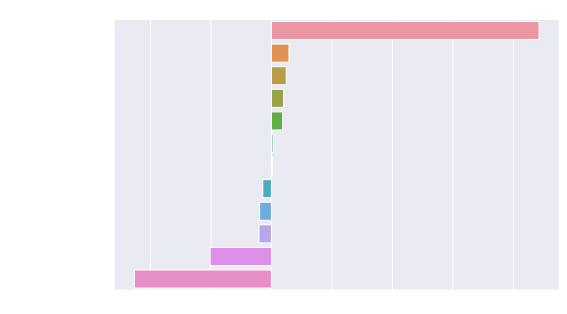

In [255]:
corr_with_target = data[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=corr_with_target.values,
            y=corr_with_target.index)

plt.title('Correlation with target')
plt.show()

**Вывод:**<br>
_Наибольший модуль коэф. корреляции с **Credit Score** и **Current Loan Amount**_

### Обработка выбросов<a class="anchor" id="outliers"></a>

**Home Ownership**<br>
Вхождения значения признака **Home Ownership** _Have Mortgage_ следует объединить в _Home Mortgage_, т.к. они несут одни и те же знания, а так же признак _Have Mortgage_ крайне редкий;

In [257]:
data.loc[data['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

**Maximum Open Credit**

In [258]:
train_df['Maximum Open Credit'].sort_values(ascending=False).head(n=3)

617    1,304,726,170.000
44       380,052,288.000
2617     265,512,874.000
Name: Maximum Open Credit, dtype: float64

In [259]:
test_df['Maximum Open Credit'].sort_values(ascending=False).head(n=3)

228    54,484,386.000
1568   26,069,956.000
2152   20,842,404.000
Name: Maximum Open Credit, dtype: float64

Заменить 3 максимальных значения признака на медианное значение, т.к. в тестовом наборе данных значения такого порядка не встречаются.

In [260]:
data.loc[data['Maximum Open Credit'] > data['Maximum Open Credit'].quantile(.9997),\
              'Maximum Open Credit'] = data['Maximum Open Credit'].median()

### Обработка пропусков<a class="anchor" id="gaps"></a>

In [261]:
len(data) - data.count()

Home Ownership                     0
Annual Income                   2070
Years in current job             457
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    5439
Bankruptcies                      17
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    2070
Credit Default                  2500
dtype: int64

**Annual Income**<br>
Заполнить медианным значением

In [262]:
data.loc[data['Annual Income'].isnull(), 'Annual Income'] = data['Annual Income'].median()

**Years in current job**<br>
Заполнить случайным распределением значений признака

In [263]:
data.loc[data['Years in current job'].isnull(), 'Years in current job'] =\
         np.random.choice(data.loc[data['Years in current job'].notnull(),\
                                        'Years in current job'].values.tolist())

**Months since last delinquent**<br>

In [264]:
data.loc[data['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0

**Bankruptcies**<br>
Заменить медианным значением

In [265]:
data.loc[data['Bankruptcies'].isnull(), 'Bankruptcies'] = data['Bankruptcies'].median()

**Credit Score**<br>

In [266]:
data.loc[data['Credit Score'].isnull(), 'Credit Score'] = data['Credit Score'].median()

### Построение новых признаков<a class="anchor" id="feature_engineering"></a>

**Соотношение ежемесячного платежа к доходу** 

In [267]:
data['monthly_debt_to_annual_income'] = data['Monthly Debt'] / data['Annual Income']

**Доля остатка по кредиту**

In [268]:
data['part_of_loan_to_pay'] = (data['Current Loan Amount'] - data['Current Credit Balance']) / data['Current Loan Amount'] * 100

**Количество месяцев до погашения текущего займа**

In [269]:
data['months_to_pay'] = data['Current Credit Balance'] / data['Monthly Debt']

**Бинарный флаг для *Bankruptcies***

In [270]:
data['was_bankrupt'] = np.where(
    data['Bankruptcies'] > 0, 1, 0
)

**Бинарный флаг для *Number of Credit Problems***

In [271]:
data['was_problems'] = np.where(
    data['Number of Credit Problems'] > 0, 1, 0
)

**Бинарный флаг для *Tax Liens*** 

In [272]:
data['is_tax_liens'] = np.where(
    data['Tax Liens'] > 0, 1, 0
)

**Была ли просрочка в прошлом месяце?**

In [273]:
data['was_delinquent_in_last_month'] = np.where(
    data['Months since last delinquent'] <= 1, 1, 0
)

### Отбор признаков<a class="anchor" id="feature_importances"></a>

In [274]:
data.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'monthly_debt_to_annual_income',
 'part_of_loan_to_pay',
 'months_to_pay',
 'was_bankrupt',
 'was_problems',
 'is_tax_liens',
 'was_delinquent_in_last_month']

In [275]:
NEW_FEATURE_NAMES = data.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

In [276]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts',
                     'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
                     'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
                     'Current Credit Balance', 'Monthly Debt', 'Credit Score']
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + NEW_FEATURE_NAMES

**Приведение типов для модели CatBoost**

In [277]:
for col_name in CAT_FEATURE_NAMES:
    data[col_name] = pd.Categorical(data[col_name])

### Нормализация данных<a class="anchor" id="normalize"></a>

In [278]:
scaler = StandardScaler()

data_norm = data.copy()
data_norm[NUM_FEATURE_NAMES + ['monthly_debt_to_annual_income',\
                               'part_of_loan_to_pay', 'months_to_pay']] =\
    scaler.fit_transform(data_norm[NUM_FEATURE_NAMES + ['monthly_debt_to_annual_income',\
                                   'part_of_loan_to_pay', 'months_to_pay']])

data = data_norm.copy()

In [279]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test<a class="anchor" id="train_test"></a>

In [280]:
train_df = data[:7500]
test_df = data[-2500:]

In [281]:
X = train_df[SELECTED_FEATURE_NAMES]
y = train_df[TARGET_NAME]

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=21) 

### Балансировка целевого класса<a class="anchor" id="class_balance"></a>

In [283]:
data_for_balancing = pd.concat([X_train, y_train], axis=1)
data_balanced = balance_df_by_target(data_for_balancing, TARGET_NAME)

data_balanced[TARGET_NAME].value_counts()

0.000    4046
1.000    3158
Name: Credit Default, dtype: int64

In [284]:
X_train = data_balanced.drop(columns=TARGET_NAME)
y_train = data_balanced[TARGET_NAME]

**Сохранение обучающего и тестового датасэта**

In [285]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [286]:
data.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Подбор моделей, получение baseline<a class="anchor" id="baseline"></a>

**CatBoost**

In [287]:
%%time

model_catb = catb(silent=True, random_state=21)
cat_features = CAT_FEATURE_NAMES
model_catb.fit(X_train, y_train, cat_features)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      4046
         1.0       0.92      0.84      0.88      3158

    accuracy                           0.90      7204
   macro avg       0.91      0.90      0.90      7204
weighted avg       0.90      0.90      0.90      7204

TEST

              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82      1341
         1.0       0.55      0.47      0.51       534

    accuracy                           0.74      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.73      0.74      0.73      1875

CONFUSION MATRIX

col_0           0.000  1.000
Credit Default              
0.000            1133    208
1.000             281    253
CPU times: user 29.5 s, sys: 3.76 s, total: 33.2 s
Wall time: 17.1 s


In [288]:
%%time

model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      4046
         1.0       0.96      0.91      0.93      3158

    accuracy                           0.94      7204
   macro avg       0.95      0.94      0.94      7204
weighted avg       0.94      0.94      0.94      7204

TEST

              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83      1341
         1.0       0.57      0.48      0.52       534

    accuracy                           0.75      1875
   macro avg       0.69      0.67      0.68      1875
weighted avg       0.74      0.75      0.74      1875

CONFUSION MATRIX

col_0           0.000  1.000
Credit Default              
0.000            1152    189
1.000             280    254
CPU times: user 1.67 s, sys: 157 ms, total: 1.83 s
Wall time: 763 ms


**XGBoost**

In [289]:
%%time

X_train = X_train.drop(columns=CAT_FEATURE_NAMES)
X_test = X_test.drop(columns=CAT_FEATURE_NAMES)

model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      4046
         1.0       0.98      0.97      0.97      3158

    accuracy                           0.98      7204
   macro avg       0.98      0.98      0.98      7204
weighted avg       0.98      0.98      0.98      7204

TEST

              precision    recall  f1-score   support

         0.0       0.79      0.84      0.81      1341
         1.0       0.52      0.43      0.47       534

    accuracy                           0.72      1875
   macro avg       0.65      0.64      0.64      1875
weighted avg       0.71      0.72      0.72      1875

CONFUSION MATRIX

col_0           0.000  1.000
Credit Default              
0.000            1129    212
1.000             305    229
CPU times: user 3.9 s, sys: 87.6 ms, total: 3.98 s
Wall time: 1.32 s


**Логистическая регрессия**

In [290]:
%%time

model_lr = LogisticRegression()
model_lr.fit(X_train.fillna(-9999), y_train)

y_train_pred = model_lr.predict(X_train.fillna(-9999))
y_test_pred = model_lr.predict(X_test.fillna(-9999))

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.66      0.85      0.74      4046
         1.0       0.69      0.43      0.53      3158

    accuracy                           0.67      7204
   macro avg       0.67      0.64      0.63      7204
weighted avg       0.67      0.67      0.65      7204

TEST

              precision    recall  f1-score   support

         0.0       0.78      0.84      0.81      1341
         1.0       0.51      0.40      0.45       534

    accuracy                           0.72      1875
   macro avg       0.64      0.62      0.63      1875
weighted avg       0.70      0.72      0.71      1875

CONFUSION MATRIX

col_0           0.000  1.000
Credit Default              
0.000            1132    209
1.000             320    214
CPU times: user 446 ms, sys: 79.1 ms, total: 526 ms
Wall time: 250 ms


**KNN**

In [291]:
%%time

model_knn = KNeighborsClassifier()
model_knn.fit(X_train.fillna(-9999), y_train)

y_train_pred = model_knn.predict(X_train.fillna(-9999))
y_test_pred = model_knn.predict(X_test.fillna(-9999))

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.78      0.84      0.81      4046
         1.0       0.77      0.69      0.73      3158

    accuracy                           0.78      7204
   macro avg       0.78      0.77      0.77      7204
weighted avg       0.78      0.78      0.78      7204

TEST

              precision    recall  f1-score   support

         0.0       0.77      0.73      0.75      1341
         1.0       0.40      0.45      0.43       534

    accuracy                           0.65      1875
   macro avg       0.59      0.59      0.59      1875
weighted avg       0.67      0.65      0.66      1875

CONFUSION MATRIX

col_0           0.000  1.000
Credit Default              
0.000             981    360
1.000             292    242
CPU times: user 2.34 s, sys: 44.9 ms, total: 2.38 s
Wall time: 2.45 s


**Вывод**:<br>
Лучше всех справился _CatBoost_<br>

BaseLine f1-score:<br>
train: 0.88<br>
test: 0.51<br>

### Подбор гиперпараметров лучшей модели<a class="anchor" id="tuning"></a>

In [292]:
model_catb = catb(class_weights=[1, 4], cat_features=cat_features, silent=True, random_state=21)

**Подбор гиперпараметров**

In [293]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [294]:
cv = KFold(n_splits=5, random_state=21, shuffle=True)

In [295]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 12.4 s, sys: 1.6 s, total: 14 s
Wall time: 4min 23s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x11d8b6af0>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [296]:
rs.best_params_

{'n_estimators': 500, 'max_depth': 5}

In [297]:
rs.best_score_

0.5401035804262938

**Обучение и оценка финальной модели**

In [304]:
%%time

final_model = catb(n_estimators=500, max_depth=3,
                   class_weights=[1, 3.5],
                   l2_leaf_reg=10, silent=True,
                   random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.98      0.28      0.44      4046
         1.0       0.52      0.99      0.68      3158

    accuracy                           0.59      7204
   macro avg       0.75      0.64      0.56      7204
weighted avg       0.78      0.59      0.54      7204

TEST

              precision    recall  f1-score   support

         0.0       0.93      0.28      0.43      1341
         1.0       0.34      0.95      0.50       534

    accuracy                           0.47      1875
   macro avg       0.64      0.61      0.47      1875
weighted avg       0.76      0.47      0.45      1875

CONFUSION MATRIX

col_0           0.000  1.000
Credit Default              
0.000             371    970
1.000              27    507
CPU times: user 3.9 s, sys: 372 ms, total: 4.28 s
Wall time: 3.59 s


### Проверка качества, борьба с переобучением<a class="anchor" id="overfitting"></a>

**Подбор порогов вероятности для определения классов** 

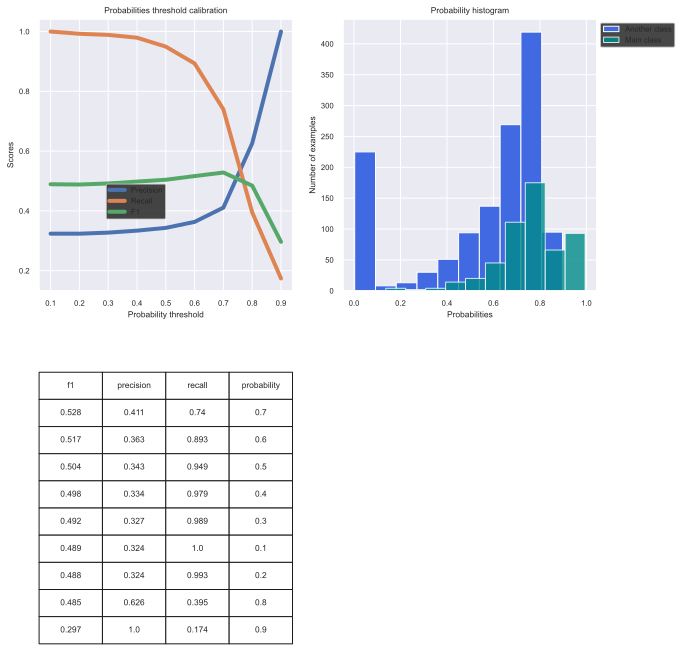

In [299]:
show_proba_calibration_plots(y_test_pred_probs[:,1], y_test)

 **Отбор признаков**

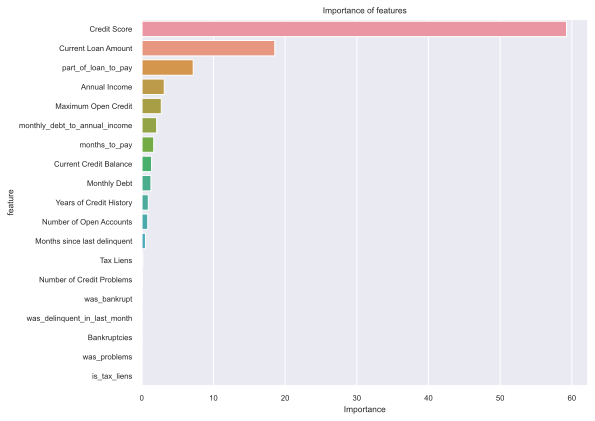

In [306]:
important_features_top = show_feature_importances(X_train.columns,
                                                  final_model.feature_importances_,
                                                  get_top=15)

In [307]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_),
                                 columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
11,Credit Score,59.253
8,Current Loan Amount,18.562
13,part_of_loan_to_pay,7.173
0,Annual Income,3.139
4,Maximum Open Credit,2.723
12,monthly_debt_to_annual_income,2.081
14,months_to_pay,1.673
9,Current Credit Balance,1.370
10,Monthly Debt,1.282
3,Years of Credit History,0.912


In [308]:
%%time

final_model = catb(n_estimators=500, max_depth=3,
                   l2_leaf_reg=10,
                   silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.73      0.86      0.79      4046
         1.0       0.77      0.59      0.67      3158

    accuracy                           0.74      7204
   macro avg       0.75      0.72      0.73      7204
weighted avg       0.75      0.74      0.74      7204

TEST

              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81      1341
         1.0       0.53      0.49      0.51       534

    accuracy                           0.73      1875
   macro avg       0.66      0.66      0.66      1875
weighted avg       0.72      0.73      0.73      1875

CONFUSION MATRIX

col_0           0.000  1.000
Credit Default              
0.000            1106    235
1.000             273    261
CPU times: user 4.19 s, sys: 741 ms, total: 4.93 s
Wall time: 13.8 s


### Вывод<a class="anchor" id="conclusions"></a>

Остановился на модели, обученной с помощью *CatBoost*, т.к. он показал приемлемую метрику<br>
__F1-score: 0.51__ на тестовом датасэте.<br>

В ТОП-3 признаков вошли:<br>
* Credit Score
* Current Loan Amount
* part_of_loan_to_pay

### Предсказание на тестовом наборе данных

In [326]:
X = test_df[important_features_top]

In [327]:
test_preds = final_model.predict(X)

In [328]:
df_test_preds = pd.DataFrame(data=test_preds,
                            columns=['Credit Default'])

In [329]:
df_test_preds.to_csv('GCaruso_predictions.csv', sep=',', encoding='utf-8')